Project repository: https://osf.io/jpzr8/?view_only=e7f22d0fcd0e44d9a8e93fd242d0851d

This notebook contains analysis that was used in the paper titled, 
### "Water mass characteristics of the Antarctic margins and the production and seasonality of Dense Shelf Water"

This is the first of the analysis notebooks

Make sure to run the Python notebooks in the following order:
1. MEOP_Preprocessing_data_SO.ipynb - if you want to generate the dfmg.csv from scratch yourself. Else, use the file provided.
2. MEOP_Analysis_Part1_OSFcopy.ipynb
3. WaterMassThickness_OSFcopy.ipynb
4. Wind_Stress_Analysis_OSFcopy.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
from matplotlib.colorbar import Colorbar 

In [2]:
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 

Ignore next 2 cells

%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

#### Read the merged dataframe "dfmg.csv" which was built using MEOP_Preprocessing_data_SO.ipynb

The pre-built "dfmg.csv" is also available for download from: https://drive.google.com/open?id=1GeUjUwLfuU840JQmxzCFKo8rrxv7eom6

In [3]:
dfmg = pd.read_csv("dfmg_corrected_DIST_IS_GL.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [6]:
dfmg["DIST_min"] = dfmg.loc[:, ["DIST_GLINE", "DIST_ISE"]].min(axis=1)

In [7]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman', 'SHELF_BREAK_PROFILE',
       'DIST_ISE', 'DIST_min'],
      dtype='object')

In [8]:
dfmg.head()

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PROFILE_NUMBER,PSAL_ADJUSTED,...,DENSITY_INSITU,POT_DENSITY,CTEMP,SA,DIST_GLINE,ECHODEPTH,gamman,SHELF_BREAK_PROFILE,DIST_ISE,DIST_min
0,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',6.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
1,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',8.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
2,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',14.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
3,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',18.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
4,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',22.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178


The next few cells import necessary custom written functions

In [9]:
import plot_theta_sal
import plot_surfbot_vsTime as pltsurfbot
import plot_topView_contourf as topView

Defining regions, water masses, and data selection masks

In [10]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])

gline_le_25km = dfmg['DIST_min'] <= 25
gline_le_50km = dfmg['DIST_min'] <= 50
gline_le_75km = dfmg['DIST_min'] <= 75
gline_le_100km = dfmg['DIST_min'] <= 100
gline_le_150km = dfmg['DIST_min'] <= 150

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

In [11]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [12]:
def play_beep():
    import os
    duration = 1  # second
    freq = np.random.randint(400,800, 10)  # Hz
    for i in range(len(freq)):
        os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq[i]))

In [13]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [58]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.4) & (dfmg.CTEMP <= -1.8) & (dfmg.CTEMP >= -1.9)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9) 

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27)

In [59]:
print(len(dfmg[DSW]), len(dfmg[ISW]), len(dfmg[lssw]), len(dfmg.loc[DSW & ISW]), 
      len(dfmg[ISW & lssw]), len(dfmg[lssw & mCDW]), len(dfmg[mCDW]))

108412 126675 182025 0 0 4 164164


In [55]:
print(len(dfmg[ISW]) )

34143


In [14]:
!mkdir ./Images/TSplots2

# Creating array of water mass images

In [16]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]

Function which creates an array of T-S plots

In [17]:
import matplotlib.gridspec as gridspec 
import matplotlib
def plot_waterMassFiguresInGrid(dfmg, regions, thetamin=[-2.5]*4, thetamax=[2]*4, salmin=[31.5]*4, mrows=3, ncols=3,
                           salmax=[35.7]*4, templine=True, s=5, alpha=1, sig_lines=[28, 28.27], wd=10, ht=10, save=False,
                           savename="./Images/TSplots/watermass.png", theta_ticks=[theta_ticks]*4, titles=[],
                           sal_ticks=[sal_ticks]*4, show_legend=False, fontsize=8, colorbar_rowspan=[0,-1]):
    plt.close(1)
    fig = plt.figure(1, figsize=(wd,ht))
    gs = gridspec.GridSpec(mrows, ncols+2, height_ratios=[1]*mrows, width_ratios=[1]*ncols+[0.03,0.05])
    
    matplotlib.rcParams.update({'axes.titlepad':6})
    axarr = []
    counter = 0

    for i in range(mrows):
        for j in range(ncols):
            axarr.append(plt.subplot(gs[i,j]) ) # place it where it should be.
            #axarr.append(plt.subplot2grid((mrows+1, ncols), (i, j)  ))
            
            print(counter)
            SC = plot_theta_sal.plot_theta_s(axarr[-1], dfmg, regions[counter], thetamin=thetamin[i], 
                                             thetamax=thetamax[i], salmin= salmin[i], salmax=salmax[i], 
                                             templine=templine, s=s, alpha=alpha, 
                                        sig_lines=sig_lines, theta_ticks= theta_ticks[i], sal_ticks=sal_ticks[i], 
                                        show_legend=show_legend, title=titles[counter], fontsize=fontsize)
            if(j > 0):
                axarr[-1].set_yticklabels([])
                axarr[-1].set_ylabel("")
                
            if(i != mrows-1):
                axarr[-1].set_xticklabels([])
                axarr[-1].set_xlabel("")
            if((i == mrows-1) and (j!=1)):
                axarr[-1].set_xlabel("")
                
            
            counter += 1
            if(counter == len(regions)):
                break
        if(counter == len(regions)):
            break
    
    cbax = plt.subplot(gs[colorbar_rowspan[0]:colorbar_rowspan[-1] , ncols+1]) # Place it where it should be.
    # --------------------------------------------------------
    cb = Colorbar(ax = cbax, mappable = SC, orientation = 'vertical', extend='max')
    cb.set_label(r'dbar', labelpad=5)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    if(save == True):
        plt.savefig(savename, dpi=300)
    plt.show()

## Watermasses Fig. 1

In [18]:
import imp
imp.reload(plot_theta_sal)

<module 'plot_theta_sal' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_theta_sal.py'>

0
1
2
3
4
5
6
7
8
9
10
11


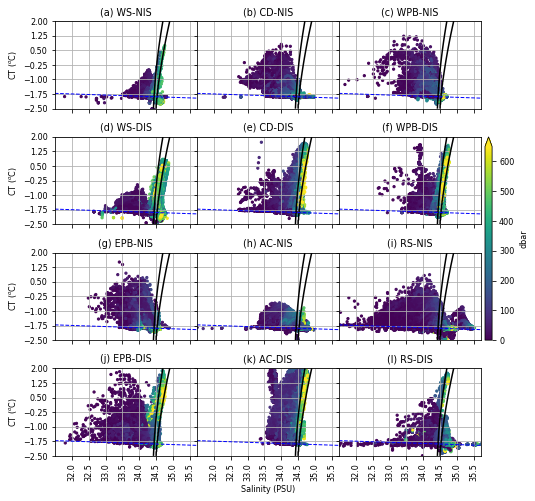

In [38]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
A1 = gline_le_50km
A2 = ~gline_le_50km
regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WS-NIS", "(b) CD-NIS", "(c) WPB-NIS",        
          "(d) WS-DIS", "(e) CD-DIS", "(f) WPB-DIS", 
          "(g) EPB-NIS","(h) AC-NIS", "(i) RS-NIS",
          "(j) EPB-DIS","(k) AC-DIS", "(l) RS-DIS" ] 
          
plot_waterMassFiguresInGrid(dfmg, regions1, titles=titles1, theta_ticks=[theta_ticks]*4, sal_ticks=[sal_ticks]*4, 
                            thetamin=[-2.5]*4, thetamax=[2]*4, save=True, 
                            savename="./Images/TSplots2/waterMass1.png", 
                            wd=7.48, ht=7, mrows=4, colorbar_rowspan=[1,3])

0
1
2
3
4
5
6
7
8
9
10
11


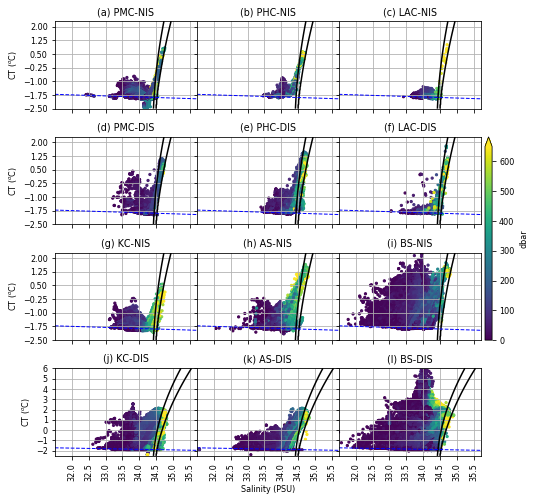

In [39]:
theta_ticks = list(np.arange(-2.5, 3.1, 0.75))
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
theta_ticks2 = list(np.arange(-2., 6.1, 1) )
A1 = gline_le_50km
A2 = ~gline_le_50km
regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMC-NIS", "(b) PHC-NIS", "(c) LAC-NIS", 
           "(d) PMC-DIS", "(e) PHC-DIS", "(f) LAC-DIS",
           "(g) KC-NIS", "(h) AS-NIS", "(i) BS-NIS", 
           "(j) KC-DIS", "(k) AS-DIS", "(l) BS-DIS"]
plot_waterMassFiguresInGrid(dfmg, regions2, titles=titles2, theta_ticks=[theta_ticks]*3+[theta_ticks2]*1, 
                            sal_ticks=[sal_ticks]*4, thetamin=[-2.5]*4,
                            thetamax=[2.3]*3+[6]*1, save=True, savename="./Images/TSplots2/waterMass2.png", 
                            wd=7.48, ht=7., mrows=4, colorbar_rowspan=[1,3])

In [71]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

# Surface Salinities, Group 1

In [21]:
import matplotlib
def plot_surfbotpropFiguresInGrid(dfmg, regions, titles=[], thetamin=-2.5, thetamax=2, salmin=31.5, mrows=3, ncols=3,
                           salmax=35.7, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], wd=10, ht=10, save=False,
                           savename="./Images/surf_bot_prop/surfprop1.png", theta_ticks=[], 
                           sal_ticks=[], show_legend=False, fontsize=8, height_ratios=[],
                           func= pltsurfbot.plot_surface_theta_sal_averages, xlabels=[], rylabels=[], lylabels=[]):
    
    matplotlib.rcParams.update({'axes.titlepad':19, 'font.size':fontsize})
    fig = plt.figure(figsize=(wd,ht))
    axarr = []
    counter = 0
    if not height_ratios:
        height_ratios = [1]*mrows 
    gs = gridspec.GridSpec(mrows, ncols, height_ratios=height_ratios, width_ratios=[1]*ncols)
    
    for i in range(mrows):
        if(height_ratios[i] < 1):
            pass
        else:
            for j in range(ncols):
                axarr.append(plt.subplot(gs[i, j]) )

                #print(counter)
                if(j > 0):
                    count_frame_on = False
                else:
                    count_frame_on=True
                theta_ax, salcount_ax, countax = func(axarr[-1], dfmg, regions[counter], title=titles[counter],
                                                     markersize=3, salmin=salmin,
                                                     salmax=salmax, thetamin=thetamin, thetamax=thetamax, 
                                                     thetaticks=theta_ticks, salticks=sal_ticks, 
                                                      show_legend=show_legend, fontsize=fontsize, 
                                                      count_frame_on=count_frame_on)
                if(j > 0):
                    axarr[-1].set_yticklabels([])
                    axarr[-1].set_ylabel("")
                    countax.set_ylim(1e-1, 5e4)
                    countax.set_axis_off()
                if((j < ncols-1) and (counter < len(regions)-1)):
                    #theta_ax.set_yticklabels([])
                    #theta_ax.set_ylabel("")
                    theta_ax.set_axis_off()
                if(i == 1 or i==4 or i==5):
                    pass
                else:
                    axarr[-1].set_xticklabels([])
                    axarr[-1].set_xlabel("")
                ## uncomment the following just for supplementary bottom figures
                #if(i == mrows-1 and j==0):
                #    theta_ax.set_yticklabels([])
                #    theta_ax.set_ylabel("")

                counter += 1
                if(counter == len(regions)):
                    break
        if(counter == len(regions)):
            break
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0.7)
    
    if(save == True):
        plt.savefig(savename, dpi=300)
    plt.show()


In [22]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

In [13]:
!mkdir ./Images/surf_bot_prop2

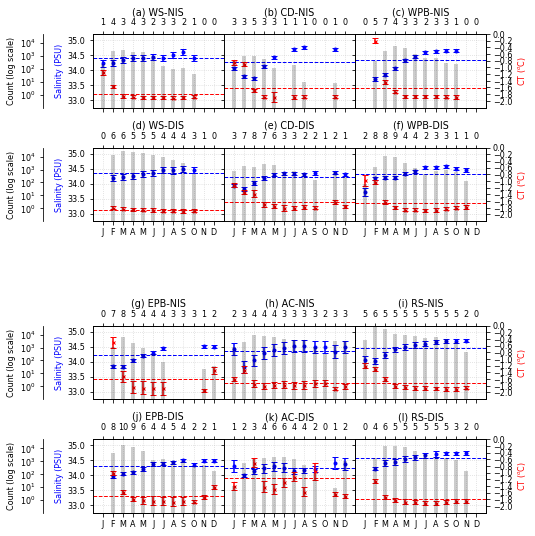

In [23]:
salticks = list(np.arange(33., 35.3, 0.5))
thetaticks = list(np.arange(-2., 0.1, 0.2))
A1 = gline_le_25km
A2 = ~gline_le_25km

titles1 = ["(a) WS-NIS", "(b) CD-NIS", "(c) WPB-NIS",        
          "(d) WS-DIS", "(e) CD-DIS", "(f) WPB-DIS", 
          "(g) EPB-NIS","(h) AC-NIS", "(i) RS-NIS",
          "(j) EPB-DIS","(k) AC-DIS", "(l) RS-DIS" ] 
regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]


plot_surfbotpropFiguresInGrid(dfmg, regions1, titles=titles1, func = pltsurfbot.plot_surface_theta_sal_averages,
                              thetamin=-2.2, thetamax=0, salmin=32.75, salmax=35.2, 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/surfprop1.png")

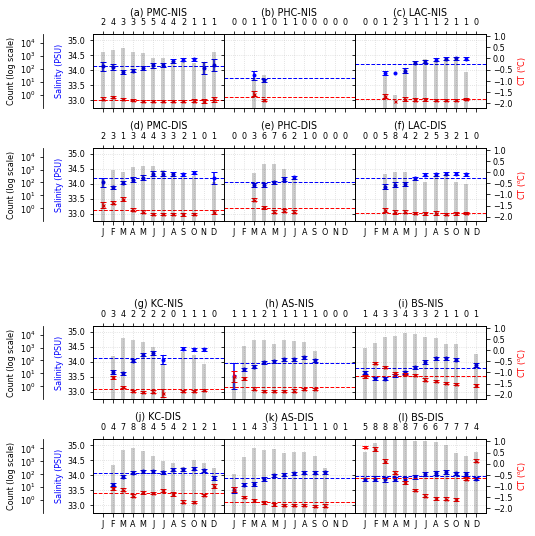

In [24]:
salticks = list(np.arange(33., 35.3, 0.5))
thetaticks = list(np.arange(-2., 1.1, 0.5))
A1 = gline_le_25km
A2 = ~gline_le_25km

regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]
titles2 = ["(a) PMC-NIS", "(b) PHC-NIS", "(c) LAC-NIS", 
           "(d) PMC-DIS", "(e) PHC-DIS", "(f) LAC-DIS",
           "(g) KC-NIS", "(h) AS-NIS", "(i) BS-NIS", 
           "(j) KC-DIS", "(k) AS-DIS", "(l) BS-DIS"]

plot_surfbotpropFiguresInGrid(dfmg, regions2, titles=titles2, thetamin=-2.2, thetamax=1.1, salmin=32.75, salmax=35.2, 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              save = True, savename="./Images/surf_bot_prop2/surfprop2.png")

# Bottom Salinities array of figures

In [25]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

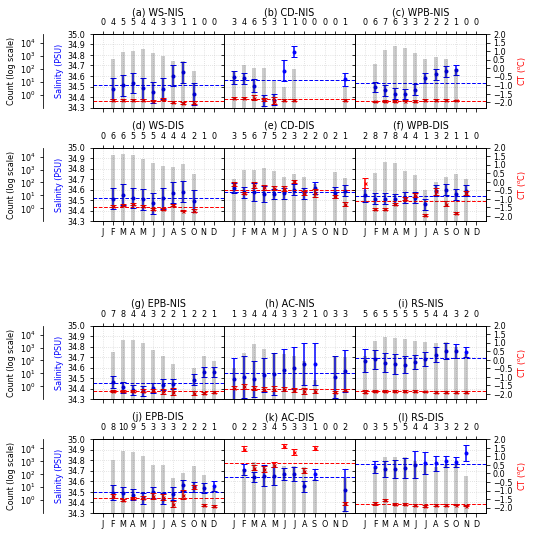

In [32]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_50km & deepMask250
B2 = ~gline_le_50km & deepMask250

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]


plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop1_250.png")

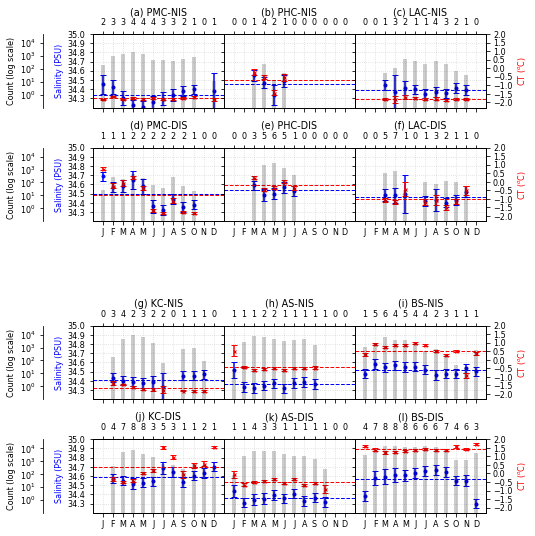

In [33]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_50km & deepMask250
B2 = ~gline_le_50km & deepMask250


regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop2_250.png")

## Supplementary figures for deeper bottom-boxes with 375m and 500m top layers

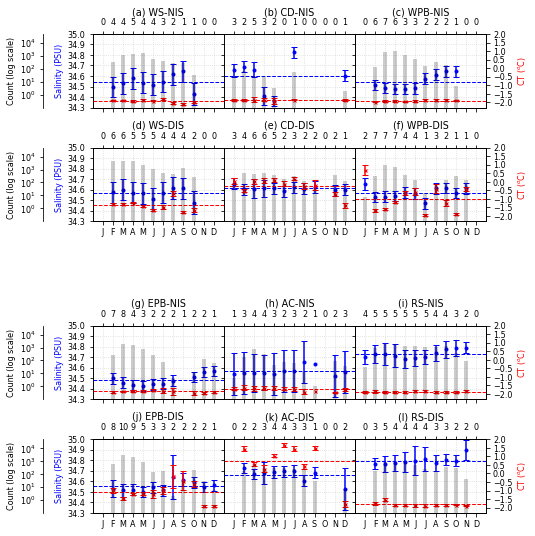

In [34]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_50km & deepMask375
B2 = ~gline_le_50km & deepMask375

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop1_375.png")

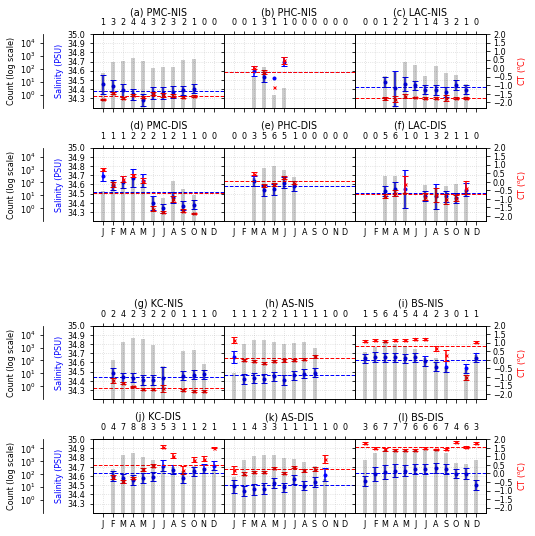

In [35]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_50km & deepMask375
B2 = ~gline_le_50km & deepMask375

regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop2_375.png")

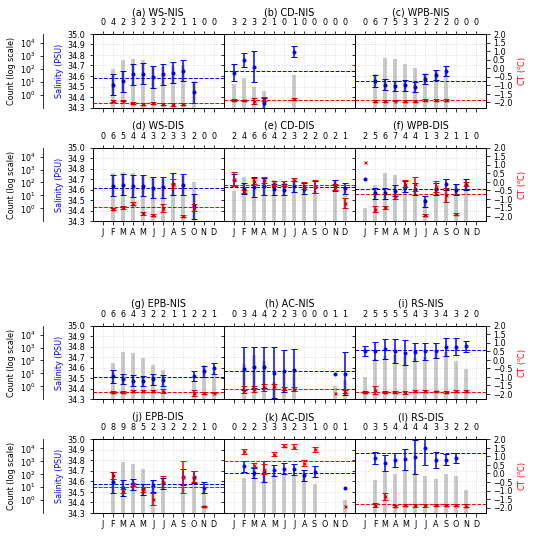

In [36]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_50km & deepMask500
B2 = ~gline_le_50km & deepMask500

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop1_500.png")

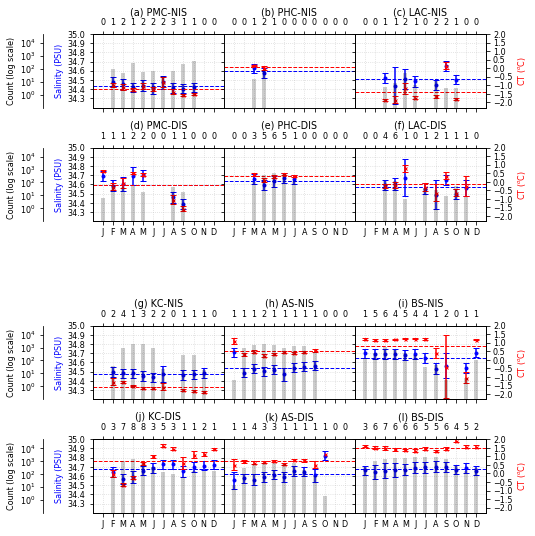

In [37]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_50km & deepMask500
B2 = ~gline_le_50km & deepMask500

regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop2_500.png")

### L2 norm between bottom depths 
L2 norm here is calculated as : $$\Large \text{L2 norm of }\Phi_{(375m-250m)} = \sqrt{ \frac{\sum_{i=1}^{i=12} (\Phi_{250_i} - \Phi_{375_i})^2}{12} } $$

Where $i$ ranges over the months. In many regions, less than 12 months of data is available. In such cases, $i$ ranges from 1 to N, where is N is the number of months with non-null data.

In [56]:
def botPropertiesL2Norm(df, region=[]):
    if not region:
        print("Error!! Region cannot be empty!!!")
        return 0
    depthMask250 = df.DEPTH <= -250
    depthMask375 = df.DEPTH <= -375
    depthMask500 = df.DEPTH <= -500
    
    salL2_375 = np.zeros(len(region))
    salL2_500 = np.zeros(len(region))
    thetaL2_375 = np.zeros(len(region))
    thetaL2_500 = np.zeros(len(region))
    salstd250, thetastd250 = np.zeros(len(region)), np.zeros(len(region))
    salstd375, thetastd375 = np.zeros(len(region)), np.zeros(len(region))
    salstd500, thetastd500 = np.zeros(len(region)), np.zeros(len(region))
    
    for i in range(len(region)):
        for area in range(2):
            salmean250 = np.array([np.nan]*12)
            salmean375 = np.array([np.nan]*12)
            salmean500 = np.array([np.nan]*12)
            thetamean250 = np.array([np.nan]*12)
            thetamean375 = np.array([np.nan]*12)
            thetamean500 = np.array([np.nan]*12)
        
        for month in range(12):
            monthMask = df.JULD.dt.month == month+1
                            
            salmean250[month] = df.loc[region[i] & monthMask & depthMask250, "PSAL_ADJUSTED"].mean()
            salmean375[month] = df.loc[region[i] & monthMask & depthMask375, "PSAL_ADJUSTED"].mean()
            salmean500[month] = df.loc[region[i] & monthMask & depthMask500, "PSAL_ADJUSTED"].mean()
                        
            thetamean250[month] = df.loc[region[i] & monthMask & depthMask250, "CTEMP"].mean()
            thetamean375[month] = df.loc[region[i] & monthMask & depthMask375, "CTEMP"].mean()
            thetamean500[month] = df.loc[region[i] & monthMask & depthMask500, "CTEMP"].mean()
            
        salstd250[i] = df.loc[region[i] & depthMask250, "PSAL_ADJUSTED"].std()    
        salstd375[i] = df.loc[region[i] & depthMask375, "PSAL_ADJUSTED"].std()
        salstd500[i] = df.loc[region[i] & depthMask500, "PSAL_ADJUSTED"].std()
        thetastd250[i] = df.loc[region[i] & depthMask250, "CTEMP"].std()
        thetastd375[i] = df.loc[region[i] & depthMask375, "CTEMP"].std()
        thetastd500[i] = df.loc[region[i] & depthMask500, "CTEMP"].std()
        
        salL2_375[i] = np.sqrt(np.nanmean((salmean250 - salmean375)**2)) #/ salstd250
        #salL2_375[i] = (np.sqrt(np.nansum((salmean250 - salmean375)**2))) #WRONG!!!!!!
        
        salL2_500[i] = np.sqrt(np.nanmean((salmean250 - salmean500)**2 )) #/ salstd250
        #salL2_500[i] = (np.sqrt(np.nansum((salmean250 - salmean500)**2 ))) #WRONG!!!!!!
        
        thetaL2_375[i] = np.sqrt(np.nanmean((thetamean250 - thetamean375)**2 )) #/ thetastd250
        #thetaL2_375[i] = (np.sqrt(np.nansum((thetamean250 - thetamean375)**2 ))) #WRONG!!!!!!!!
        
        thetaL2_500[i] = np.sqrt(np.nanmean((thetamean250 - thetamean500)**2 )) #/ thetastd250
        #thetaL2_500[i] = (np.sqrt(np.nansum((thetamean250 - thetamean500)**2 ))) #WRONG!!!!!!!
    
    return salL2_375, salL2_500, thetaL2_375, thetaL2_500, [salstd250, salstd375, salstd500, thetastd250, \
            thetastd375, thetastd500]

In [57]:
A1 = gline_le_50km
A2 = ~gline_le_50km

regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 


regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

salL2_375, salL2_500, thetaL2_375, thetaL2_500, stds = botPropertiesL2Norm(dfmg, region=regions1+regions2)

In [58]:
regions_list = titles1 + titles2

for i in range(len(regions_list)):
    print(regions_list[i], '{:0.2f}'.format(stds[0][i]), 
                                    '{:0.2f}'.format(salL2_375[i])+'({:0.2f}'.format(stds[1][i])+")", 
                                    '{:0.2f}'.format(salL2_500[i])+"({:0.2f}".format(stds[2][i])+")",  
                                    '{:0.2f}'.format(stds[3][i]),
                                    '{:0.2f}'.format(thetaL2_375[i])+"({:0.2f}".format(stds[4][i])+")",  
                                    '{:0.2f}'.format(thetaL2_500[i])+"({:0.2f}".format(stds[5][i])+")")

(a) WSA1 0.09 0.04(0.08) 0.09(0.07) 0.24 0.03(0.29) 0.17(0.18)
(b) CDA1 0.19 0.08(0.16) 0.11(0.12) 0.16 0.09(0.05) 0.12(0.03)
(c) WPBA1 0.09 0.02(0.06) 0.05(0.05) 0.07 0.02(0.06) 0.01(0.05)
(d) WSA2 0.11 0.05(0.10) 0.11(0.10) 0.62 0.24(0.68) 0.47(0.78)
(e) CDA2 0.09 0.03(0.08) 0.05(0.07) 1.06 0.30(1.00) 0.32(0.88)
(f) WPBA2 0.07 0.04(0.07) 0.07(0.07) 0.87 0.28(0.96) 0.57(1.11)
(g) EPBA1 0.10 0.03(0.08) 0.06(0.06) 0.10 0.03(0.08) 0.04(0.06)
(h) ACA1 0.08 0.03(0.05) 0.06(0.04) 0.18 0.03(0.17) 0.10(0.15)
(i) RSA1 0.09 0.05(0.08) 0.09(0.08) 0.18 0.03(0.22) 0.05(0.37)
(j) EPBA2 0.10 0.07(0.10) 0.09(0.11) 0.73 0.58(0.92) 0.73(1.06)
(k) ACA2 0.09 0.03(0.07) 0.05(0.05) 1.15 0.22(0.95) 0.29(0.79)
(l) RSA2 0.11 0.04(0.11) 0.08(0.12) 0.38 0.03(0.42) 0.09(0.45)
(a) PMCA1 0.14 0.06(0.09) 0.13(0.08) 0.31 0.15(0.41) 0.59(0.51)
(b) PHCA1 0.14 0.15(0.12) 0.09(0.09) 0.74 0.56(0.63) 0.48(0.44)
(c) LACA1 0.06 0.03(0.06) 0.14(0.08) 0.20 0.05(0.29) 0.78(0.83)
(d) PMCA2 0.21 0.05(0.16) 0.09(0.14) 1.14 0.23(1

In [59]:
regions_list = titles1 + titles2

for i in range(len(regions_list)):
    print(regions_list[i], '{:0.2f}'.format(stds[0][i]), 
                                    '{:0.2f}'.format(salL2_375[i]),#+'({:0.2f}'.format(stds[1][i])+")", 
                                    '{:0.2f}'.format(salL2_500[i]),#+"({:0.2f}".format(stds[2][i])+")",  
                                    '{:0.2f}'.format(stds[3][i]),
                                    '{:0.2f}'.format(thetaL2_375[i]),#+"({:0.2f}".format(stds[4][i])+")",  
                                    '{:0.2f}'.format(thetaL2_500[i]))#+"({:0.2f}".format(stds[5][i])+")")

(a) WSA1 0.09 0.04 0.09 0.24 0.03 0.17
(b) CDA1 0.19 0.08 0.11 0.16 0.09 0.12
(c) WPBA1 0.09 0.02 0.05 0.07 0.02 0.01
(d) WSA2 0.11 0.05 0.11 0.62 0.24 0.47
(e) CDA2 0.09 0.03 0.05 1.06 0.30 0.32
(f) WPBA2 0.07 0.04 0.07 0.87 0.28 0.57
(g) EPBA1 0.10 0.03 0.06 0.10 0.03 0.04
(h) ACA1 0.08 0.03 0.06 0.18 0.03 0.10
(i) RSA1 0.09 0.05 0.09 0.18 0.03 0.05
(j) EPBA2 0.10 0.07 0.09 0.73 0.58 0.73
(k) ACA2 0.09 0.03 0.05 1.15 0.22 0.29
(l) RSA2 0.11 0.04 0.08 0.38 0.03 0.09
(a) PMCA1 0.14 0.06 0.13 0.31 0.15 0.59
(b) PHCA1 0.14 0.15 0.09 0.74 0.56 0.48
(c) LACA1 0.06 0.03 0.14 0.20 0.05 0.78
(d) PMCA2 0.21 0.05 0.09 1.14 0.23 0.41
(e) PHCA2 0.16 0.05 0.11 0.96 0.25 0.55
(f) LACA2 0.11 0.05 0.13 0.84 0.33 0.99
(g) KCA1 0.09 0.04 0.07 0.27 0.03 0.07
(h) ASA1 0.22 0.09 0.17 0.93 0.49 0.91
(i) BSA1 0.16 0.11 0.14 0.64 0.42 0.56
(j) KCA2 0.15 0.04 0.09 1.32 0.21 0.52
(k) ASA2 0.20 0.16 0.28 1.09 0.83 1.26
(l) BSA2 0.19 0.09 0.15 0.55 0.13 0.16


## CDW locations around Antarctica

Location of profiles detecting CDW

In [37]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [38]:
CDW = (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP > 0)

In [39]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

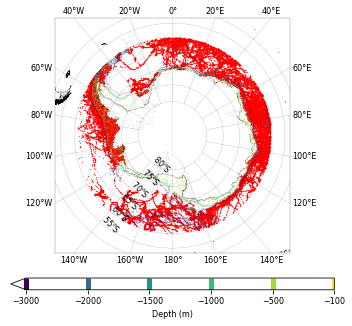

In [78]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/CDWpositions.png")

In [101]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Weddell",
                              save=True, savename="./Images/dataDensity/WS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5659861x5523520 pixels is too large. It must be less than 2^16 in each direction.

In [102]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Ross",
                              save=True, savename="./Images/dataDensity/RS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8719894x9170325 pixels is too large. It must be less than 2^16 in each direction.

In [42]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Knox", plotBathy=True,
                              save=True, savename="./Images/dataDensity/KC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9722182x5929885 pixels is too large. It must be less than 2^16 in each direction.

In [99]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Adelie",
                              save=True, savename="./Images/dataDensity/AC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9969746x7005558 pixels is too large. It must be less than 2^16 in each direction.

In [52]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [53]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Prydz",
                              save=True, savename="./Images/dataDensity/CD_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8467006x5464788 pixels is too large. It must be less than 2^16 in each direction.

In [103]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Amundsen",
                              save=True, savename="./Images/dataDensity/AS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5817855x9535680 pixels is too large. It must be less than 2^16 in each direction.

In [104]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Belingshausen",
                              save=True, savename="./Images/dataDensity/BS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5368344x7915358 pixels is too large. It must be less than 2^16 in each direction.

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


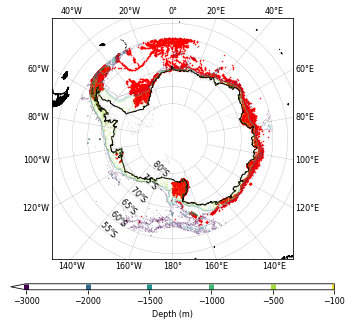

In [38]:
mCDWpositions = dfmg.loc[mCDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(mCDWpositions, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/mCDWpositions.png")

In [10]:
def return_CT_mean_formalError(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = float(df.loc[mask, var].count())
    print("count", CTcount, "sd", CTsd)
    error1 = CTerrorMean 
    error2 = (1.96 * CTsd / np.sqrt(CTcount))
    error3 = np.sqrt(error1**2 + error2**2)
    
    return round(CTmean,2) , error1, CTsd, error2, error3

In [25]:
return_CT_mean_formalError(dfmg, Prydz & gline_le_75km & deepMask250 & sel_months(dfmg, [9]), var="PSAL_ADJUSTED" )

count 595.0 sd 0.027785509181720895


(34.64,
 0.05000000074505806,
 0.027785509181720895,
 0.0022326258474338815,
 0.05004982210438351)

In [10]:
def return_CT_mean(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = df.loc[mask, var].count()
    
    error = np.sqrt(CTerrorMean**2 + (1.96 * CTsd / np.sqrt(CTcount))**2)
    
    return round(CTmean,2) , error

In [21]:
return_CT_mean(dfmg, AS & gline_le_75km & deepMask500)

(0.35, 0.052746463356250543)

In [72]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250)

(-1.75, 0.046551529449024444)

In [73]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250, var="PSAL_ADJUSTED")

(34.3, 0.063763968423933781)

In [13]:
return_CT_mean(dfmg, LAC & gline_le_75km & deepMask500)

(-0.88, 0.20277397804359704)

In [14]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask500)

(-1.49, 0.05407613216137537)

In [15]:
return_CT_mean(dfmg, CDP & gline_le_75km & deepMask500)

(-1.81, 0.14933881212951569)